We want now a script to compare across designs, and the effects of their differences on the produced H fields. In this example, I will be looking at the residual H field effects of adding a helix to an uncoupled TE102 cavity

In [1]:
from matplotlib import *
from pylab import *
from numpy import *
from pyspecdata import *

In [2]:
fl = figlist_var()

In [3]:
def construct_axes_from_positions(positions):
    #{{{ construct the axes
    list_of_axes = [unique(positions[:,j]) for j in range(0,3)]
    list_of_indeces = [0,1,2]
    for j in range(0,len(list_of_axes)):
        if len(list_of_axes[j]) == 1:
            list_of_axes.pop(j)
            list_of_indeces.pop(j)
            break
    [u_axis,v_axis] = list_of_axes
    [u_index,v_index] = list_of_indeces
    return u_index,v_index,u_axis,v_axis
    #}}}

In [4]:
def load_hfss_vectors(filename,show_valid = False):
    fp = open(filename,'r')
    data = fp.readlines()
    fp.close()
    header = data[0:2]
    print("the second line tells me what's in the file -- x,y,z, followed by the 3 positions of vector data and the final part tells me what it is")
    print('header is',r'\begin{verbatim}', header, r'\end{verbatim}')
    data = data[2:]
    positions = empty((len(data),3),dtype = 'double')
    vec_vals = empty((len(data),3),dtype = 'double')
    for j,line in enumerate(data):
        vals = [double(x) for x in line.strip().split(" ") if len(x)>0]
        positions[j,:] = vals[0:3]
        vec_vals[j,:] = vals[3:]
    u_index,v_index,u_axis,v_axis = construct_axes_from_positions(positions)
    #{{{ show the datapoints and which are valid
    if show_valid:
        fl.next('show valid values')
        thismask = isnan(vec_vals[:,u_index])
        print("invalid/valid",sum(thismask), sum(~thismask))
        fl.plot(positions[:,u_index][thismask],positions[:,v_index][thismask],'r.')
        fl.plot(positions[:,u_index][~thismask],positions[:,v_index][~thismask],'b.') # '~' = 'not'
        xlabel('u')
        ylabel('v')
        gca().set_aspect('equal', 'datalim')
    #}}}
    data = empty((len(u_axis),len(v_axis),3),dtype = 'double')
    for j in range(0,positions.shape[0]):
        u_i = where(u_axis == positions[j,u_index])[0][0]
        v_i = where(v_axis == positions[j,v_index])[0][0]
        data[u_i,v_i,:] = vec_vals[j,:]
    return u_index,u_axis,v_index,v_axis,data

Load in all files (real + imag for both designs)

In [5]:
filenames_w_helix = (
    '240607_VectorH_Uncoupled_w-helix_1mode_0deg.fld', #0 degrees, real
    '240607_VectorH_Uncoupled_w-helix_1mode_90deg.fld', #90 degrees, imag
)
filenames_wout_helix = (
    '240607_VectorH_Uncoupled_wout-helix_1mode_0deg.fld', #0 degrees, real
    '240607_VectorH_Uncoupled_wout-helix_1mode_90deg.fld', #90 degrees, imag
)

In [6]:
axis_names = ['x','y','z']
def load_hfss_vectors_as_nddata(filename2):
    u_index, u_axis, v_index, v_axis, data2 = load_hfss_vectors(filename2)
    return nddata(data2, data2.shape, [axis_names[u_index], axis_names[v_index], 'vec']).setaxis(
        axis_names[u_index], u_axis).setaxis(axis_names[v_index], v_axis).setaxis('vec',r_[0,1,2])
def load_hfss_complex_vectors(real_plus_imag):
    return ( load_hfss_vectors_as_nddata(real_plus_imag[0]) #real, 0 degree
            + 1j * load_hfss_vectors_as_nddata(real_plus_imag[1])) #imag, 90 degree
def load_hfss_subtract_vectors(no_helix_vs_helix):
    return ( load_hfss_vectors_as_nddata(no_helix_vs_helix[1]) #with helix
         - load_hfss_vectors_as_nddata(no_helix_vs_helix[0])) #- no helix

the second line tells me what's in the file -- x,y,z, followed by the 3 positions of vector data and the final part tells me what it is
header is \begin{verbatim} ['Grid Output Min: [-25mm 0mm -20mm] Max: m 0mm 20mm] Grid Size: m 0mm 1mm]\n', 'X, Y, Z, Vector data "Vector_H"\n'] \end{verbatim}
the second line tells me what's in the file -- x,y,z, followed by the 3 positions of vector data and the final part tells me what it is
header is \begin{verbatim} ['Grid Output Min: [-25mm 0mm -20mm] Max: m 0mm 20mm] Grid Size: m 0mm 1mm]\n', 'X, Y, Z, Vector data "Vector_H"\n'] \end{verbatim}


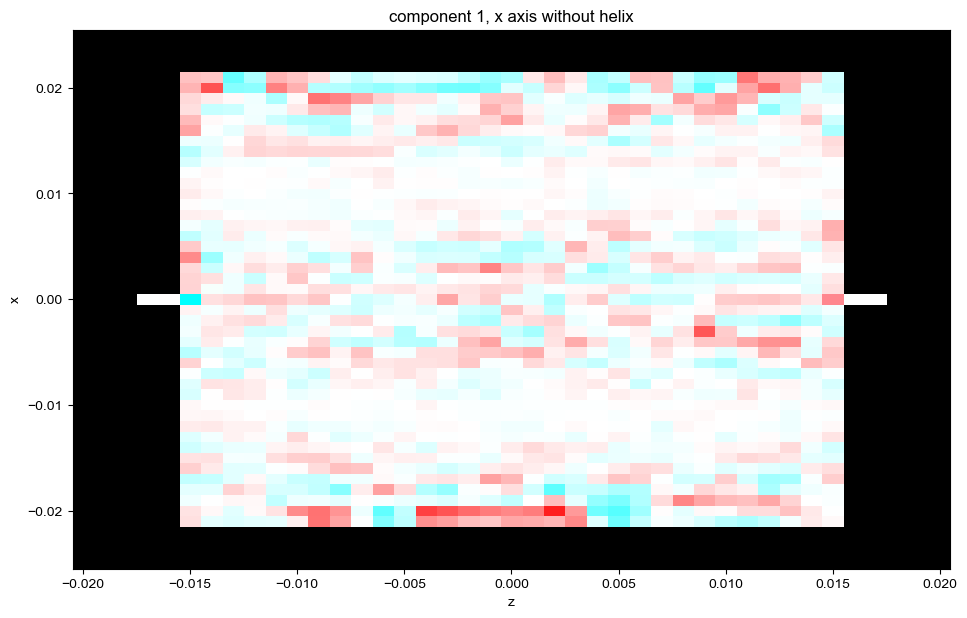

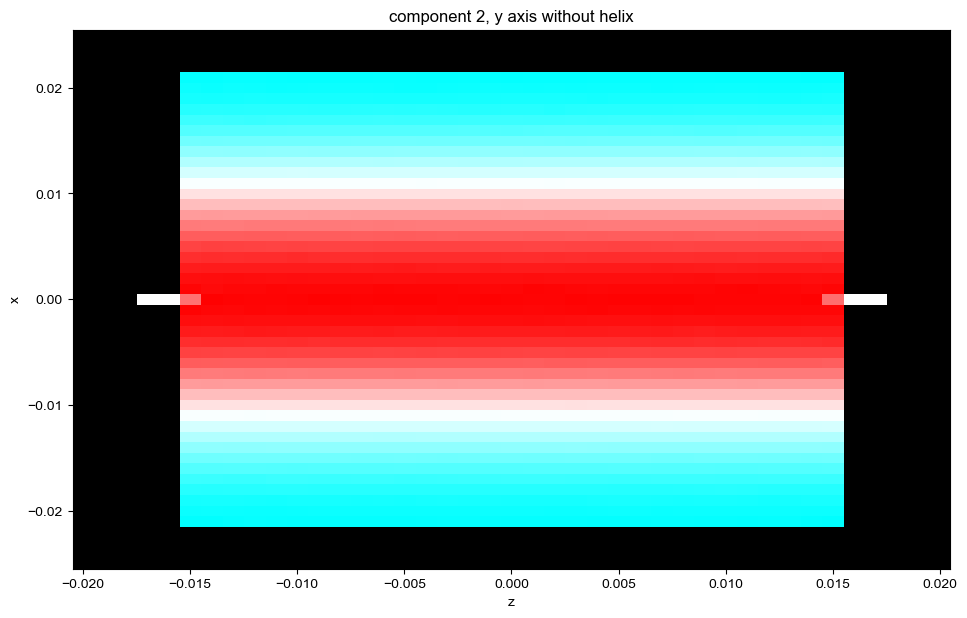

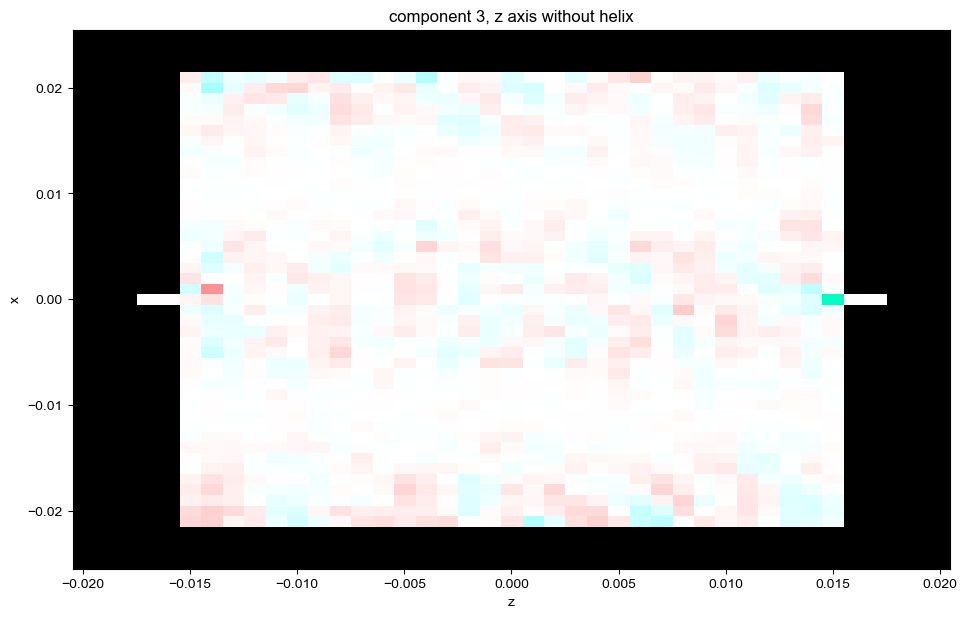

In [7]:
d_nohelix = load_hfss_complex_vectors(filenames_wout_helix)
d_nohelix *= -1j
for j in range(3):
    figure(j+1)
    title(f'component {j+1}, {axis_names[j]} axis without helix')
    image(d_nohelix['vec',j])

the second line tells me what's in the file -- x,y,z, followed by the 3 positions of vector data and the final part tells me what it is
header is \begin{verbatim} ['Grid Output Min: [-25mm 0mm -20mm] Max: m 0mm 20mm] Grid Size: m 0mm 1mm]\n', 'X, Y, Z, Vector data "Vector_H"\n'] \end{verbatim}
the second line tells me what's in the file -- x,y,z, followed by the 3 positions of vector data and the final part tells me what it is
header is \begin{verbatim} ['Grid Output Min: [-25mm 0mm -20mm] Max: m 0mm 20mm] Grid Size: m 0mm 1mm]\n', 'X, Y, Z, Vector data "Vector_H"\n'] \end{verbatim}


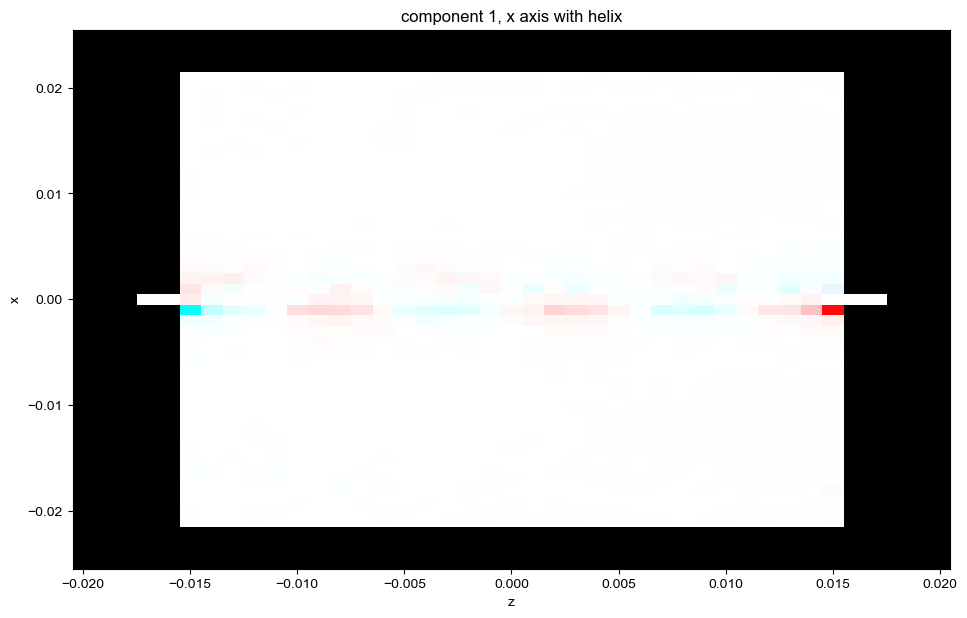

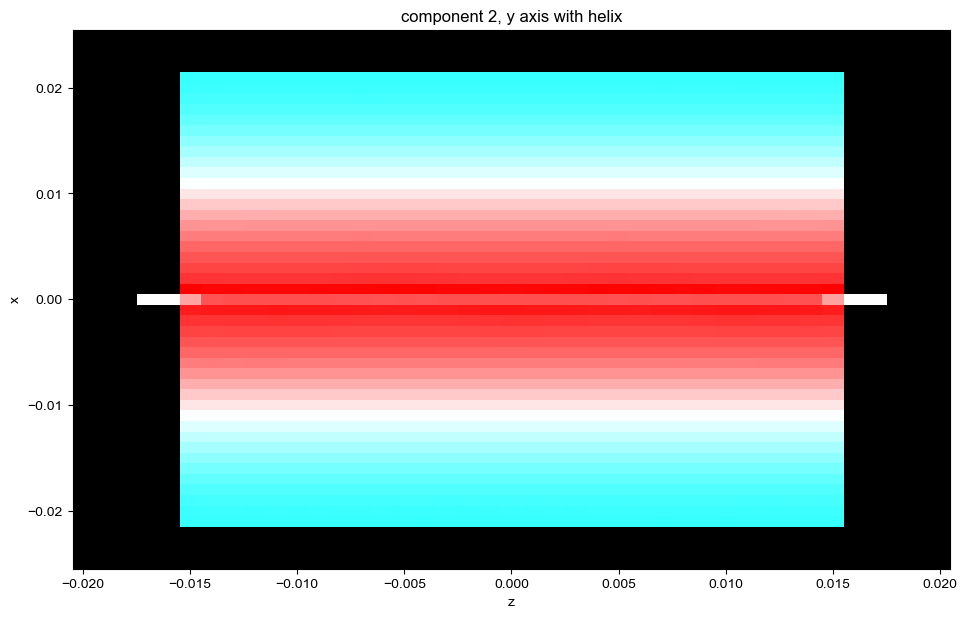

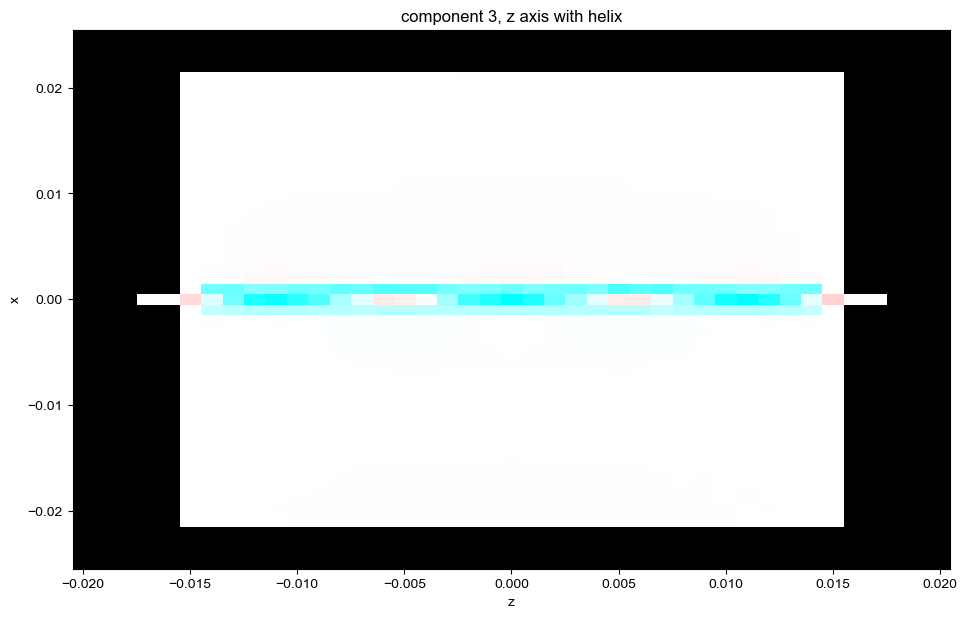

In [8]:
d_whelix = load_hfss_complex_vectors(filenames_w_helix)
d_whelix *= 1j
for j in range(3):
    figure(3+j+1)
    title(f'component {j+1}, {axis_names[j]} axis with helix')
    image(d_whelix['vec',j])

[(51, 'x'), (41, 'z'), (3, 'vec')]


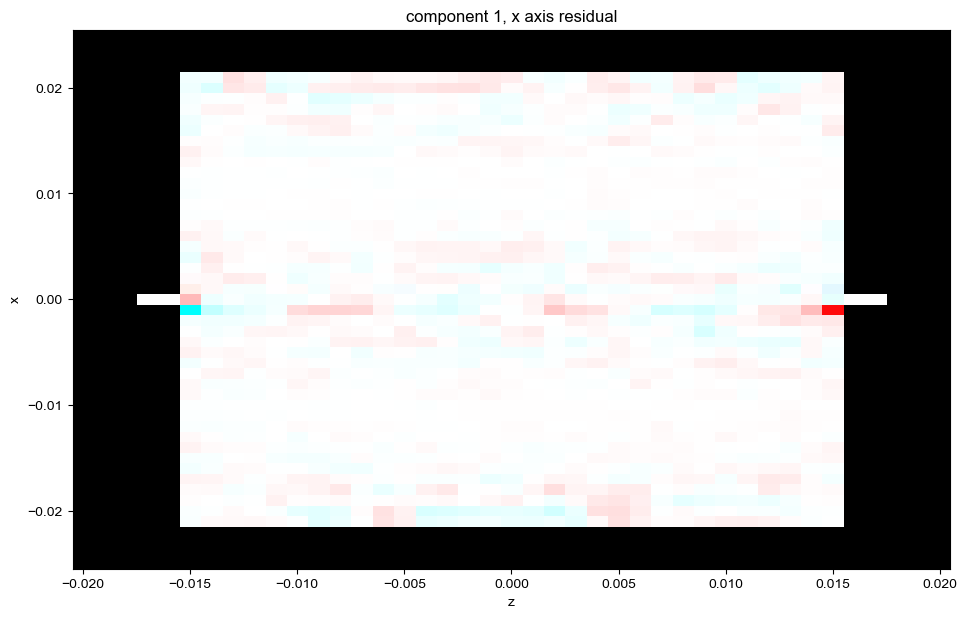

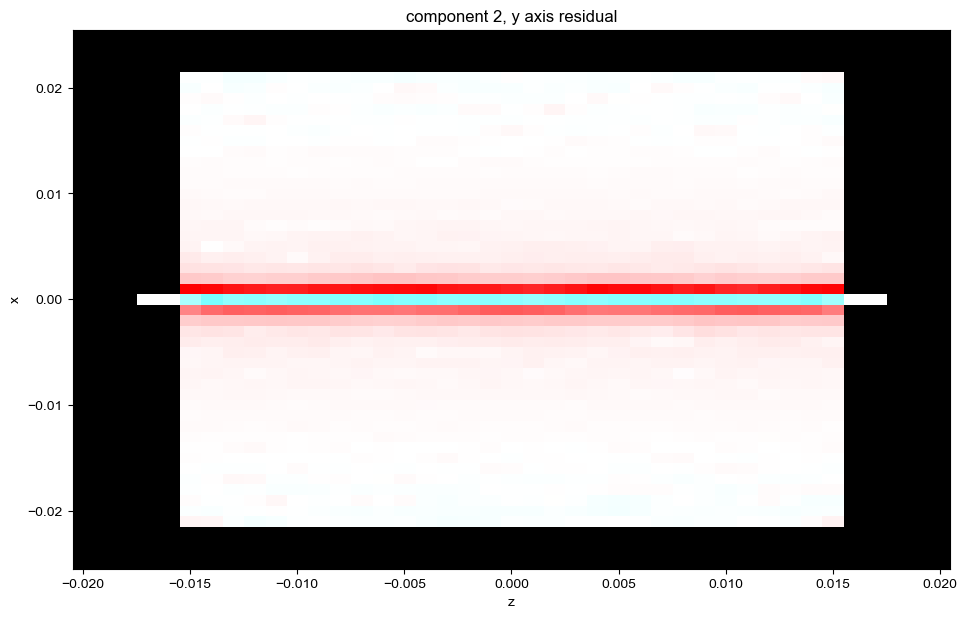

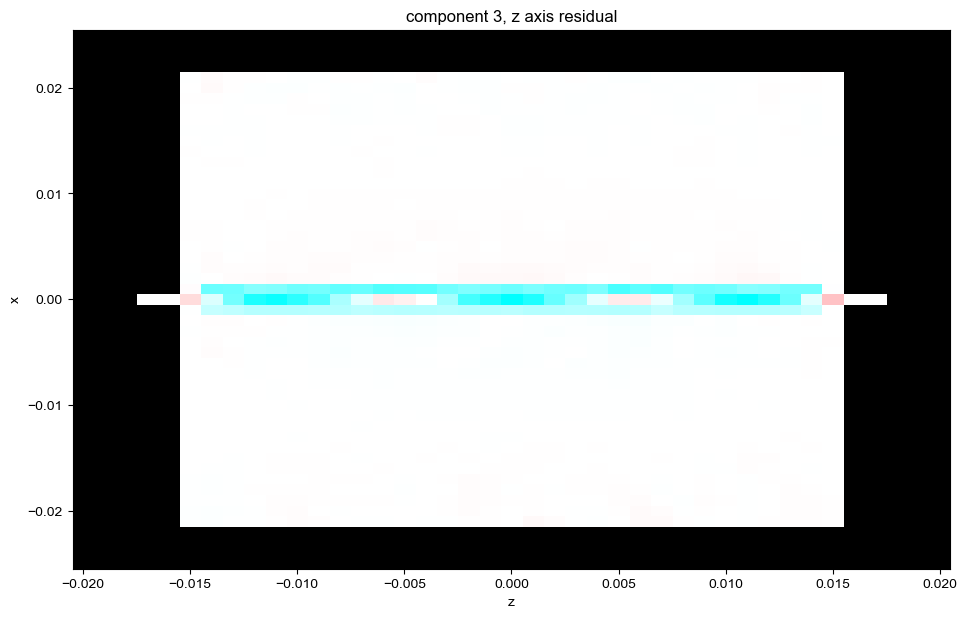

In [9]:
d_subtract = d_whelix - d_nohelix
print(shape(d_subtract))
for j in range(3):
    figure(6+j+1)
    title(f'component {j+1}, {axis_names[j]} axis residual')
    image(d_subtract['vec',j])

In [10]:
d_subtract.run(lambda x:
        abs(x)**2).sum('vec').run(sqrt)
print(shape(d_subtract))

[(51, 'x'), (41, 'z')]


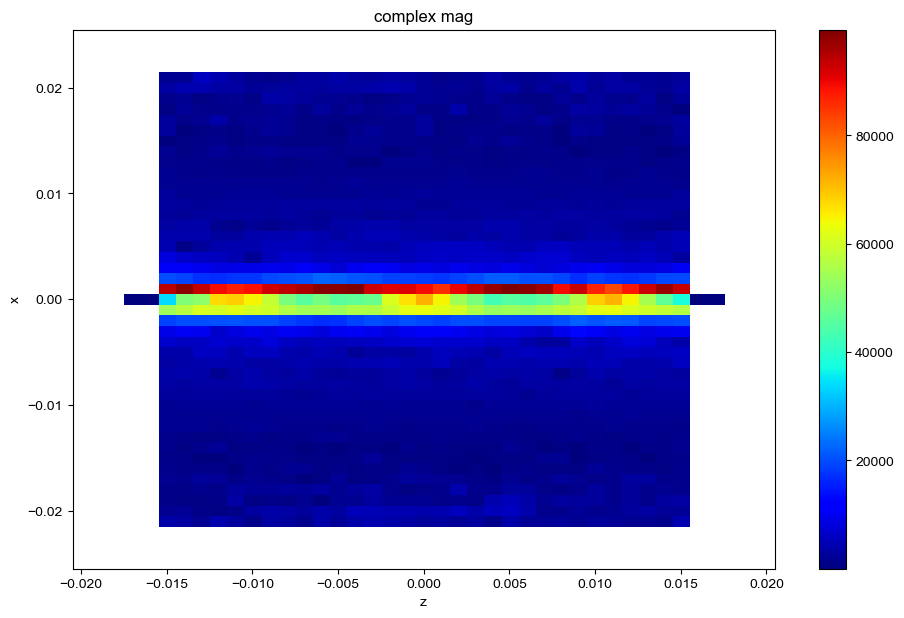

In [11]:
figure(10)
title('complex mag')
image(d_subtract)

In [12]:
fl.show()